In [1]:
%%capture
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
%run "EDA.ipynb"

Nettoyage terminé.

Lancement de l'optimisation Gradient Boosting... (Peut être plus long que Random Forest)
Fitting 3 folds for each of 24 candidates, totalling 72 fits

MEILLEURS PARAMÈTRES : {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

--- PERFORMANCE (GRADIENT BOOSTING) ---
MAE (Erreur moyenne)  : 0.4249 tonnes/ha
RMSE (Erreur quadratique): 0.6422 tonnes/ha
R² (Précision globale): 0.4287


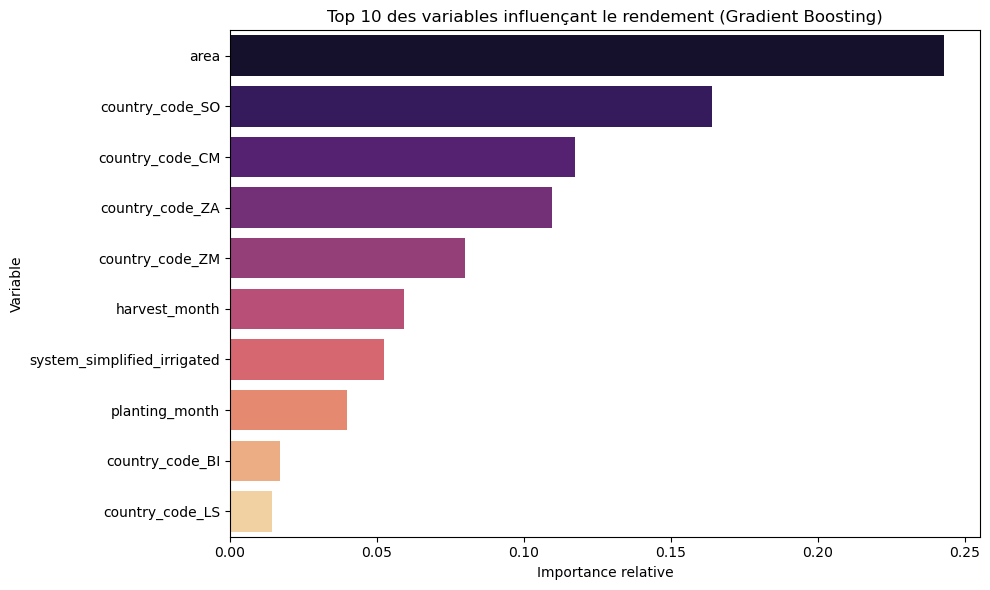

In [2]:
# Création de la colonne simplifiée
df_clean['system_simplified'] = 'other'
sys_lower = df_clean['crop_production_system'].str.lower()

# Règles de standardisation (Identiques au modèle précédent pour comparabilité)
mask_irrigated = sys_lower.str.contains('irrigated|water|dam|riverine', na=False)
df_clean.loc[mask_irrigated, 'system_simplified'] = 'irrigated'

mask_rainfed = sys_lower.str.contains('rainfed|dieri|recessional', na=False)
df_clean.loc[mask_rainfed, 'system_simplified'] = 'rainfed'

mask_commercial = sys_lower.str.contains('commercial|mechanized|large_scale|lscf', na=False)
df_clean.loc[mask_commercial, 'system_simplified'] = 'commercial_mechanized'

mask_traditional = sys_lower.str.contains('traditional|communal|small|pastoral|sscf|a1|a2', na=False)
df_clean.loc[mask_traditional, 'system_simplified'] = 'traditional_small_scale'

mask_unknown = sys_lower.str.contains('all|none|or \(ps\)', na=False)
df_clean.loc[mask_unknown, 'system_simplified'] = 'general_unknown'

print("Nettoyage terminé.")

features_cols = ['country_code', 'season_name', 'planting_month', 
                 'harvest_month', 'area', 'system_simplified']

X = df_clean[features_cols]
y = df_clean['yield']

# Encodage One-Hot
X = pd.get_dummies(X, columns=['country_code', 'season_name', 'system_simplified'], drop_first=True)

# Division Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paramètres spécifiques au Gradient Boosting
# learning_rate : Vitesse d'apprentissage (plus il est bas, plus il faut d'arbres)
param_grid = {
    'n_estimators': [100, 200],      # Nombre d'arbres
    'learning_rate': [0.05, 0.1, 0.2], # Pas d'apprentissage
    'max_depth': [3, 5],             # Profondeur (GB est plus sensible au sur-apprentissage que RF)
    'subsample': [0.8, 1.0]          # Fraction des données utilisées pour chaque arbre (0.8 réduit le sur-apprentissage)
}

# Initialisation du modèle
gbr = GradientBoostingRegressor(random_state=42)

# Configuration de la recherche
grid_search = GridSearchCV(estimator=gbr, 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=1, 
                           scoring='r2')

print("\nLancement de l'optimisation Gradient Boosting... (Peut être plus long que Random Forest)")
grid_search.fit(X_train, y_train)

# =============================================================================
# ÉVALUATION ET RÉSULTATS
# =============================================================================
print("\n" + "="*50)
print(f"MEILLEURS PARAMÈTRES : {grid_search.best_params_}")
print("="*50)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n--- PERFORMANCE (GRADIENT BOOSTING) ---")
print(f"MAE (Erreur moyenne)  : {mae:.4f} tonnes/ha")
print(f"RMSE (Erreur quadratique): {rmse:.4f} tonnes/ha")
print(f"R² (Précision globale): {r2:.4f}")

# =============================================================================
# VISUALISATION DES FACTEURS IMPORTANTS
# =============================================================================
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='magma')
plt.title('Top 10 des variables influençant le rendement (Gradient Boosting)')
plt.xlabel('Importance relative')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [3]:
# Sauvegarde du modèle Gradient Boosting

model_path = '../ml_models_pkg/gb_model.pkl'
joblib.dump(best_model, model_path)
print(f"Modèle Gradient Boosting sauvegardé à : {model_path}")

# Sauvegarde aussi la configuration des features (noms des colonnes)
# Cela sera nécessaire pour faire des prédictions futures
features_path = '../ml_models_pkg/gb_feature_names.pkl'
joblib.dump(X.columns.tolist(), features_path)
print(f"Noms des features sauvegardés à : {features_path}")

Modèle Gradient Boosting sauvegardé à : ../ml_models_pkg/gb_model.pkl
Noms des features sauvegardés à : ../ml_models_pkg/gb_feature_names.pkl
